In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

0 1 0


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

print(torch.__version__)
torch.cuda.is_available()

1.12.0+cu102


True

In [3]:
import numpy as np
import string, sys, getopt

alpha_1 = list("ARNDCQEGHILKMFPSTWYV-")
states = len(alpha_1)
alpha_3 = ['ALA','ARG','ASN','ASP','CYS','GLN','GLU','GLY','HIS','ILE',
           'LEU','LYS','MET','PHE','PRO','SER','THR','TRP','TYR','VAL','GAP']

aa_1_N = {a:n for n,a in enumerate(alpha_1)}
aa_3_N = {a:n for n,a in enumerate(alpha_3)}
aa_N_1 = {n:a for n,a in enumerate(alpha_1)}
aa_1_3 = {a:b for a,b in zip(alpha_1,alpha_3)}
aa_3_1 = {b:a for a,b in zip(alpha_1,alpha_3)}

def AA_to_N(x):
  # ["ARND"] -> [[0,1,2,3]]
  x = np.array(x);
  if x.ndim == 0: x = x[None]
  return [[aa_1_N.get(a, states-1) for a in y] for y in x]

def N_to_AA(x):
  # [[0,1,2,3]] -> ["ARND"]
  x = np.array(x);
  if x.ndim == 1: x = x[None]
  return ["".join([aa_N_1.get(a,"-") for a in y]) for y in x]

def parse_PDB(x, atoms=['N','CA','C'], chain=None):
  '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, atoms, coords=(x,y,z)), sequence
  '''
  xyz,seq,min_resn,max_resn = {},{},np.inf,-np.inf
  for line in open(x,"rb"):
    line = line.decode("utf-8","ignore").rstrip()

    if line[:6] == "HETATM" and line[17:17+3] == "MSE":
      line = line.replace("HETATM","ATOM  ")
      line = line.replace("MSE","MET")

    if line[:4] == "ATOM":
      ch = line[21:22]
      if ch == chain or chain is None:
        atom = line[12:12+4].strip()
        resi = line[17:17+3]
        resn = line[22:22+5].strip()
        x,y,z = [float(line[i:(i+8)]) for i in [30,38,46]]

        if resn[-1].isalpha(): resa,resn = resn[-1],int(resn[:-1])-1
        else: resa,resn = "",int(resn)-1
        if resn < min_resn: min_resn = resn
        if resn > max_resn: max_resn = resn
        if resn not in xyz: xyz[resn] = {}
        if resa not in xyz[resn]: xyz[resn][resa] = {}
        if resn not in seq: seq[resn] = {}
        if resa not in seq[resn]: seq[resn][resa] = resi

        if atom not in xyz[resn][resa]:
          xyz[resn][resa][atom] = np.array([x,y,z])

  # convert to numpy arrays, fill in missing values
  seq_,xyz_ = [],[]
  for resn in range(min_resn,max_resn+1):
    if resn in seq:
      for k in sorted(seq[resn]): seq_.append(aa_3_N.get(seq[resn][k],20))
    else: seq_.append(20)
    if resn in xyz:
      for k in sorted(xyz[resn]):
        for atom in atoms:
          if atom in xyz[resn][k]: xyz_.append(xyz[resn][k][atom])
          else: xyz_.append(np.full(3,np.nan))
    else:
      for atom in atoms: xyz_.append(np.full(3,np.nan))
  return np.array(xyz_).reshape(-1,len(atoms),3), np.array(seq_)

def extend(a,b,c, L,A,D):
  '''
  input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
  output: 4th coord
  '''
  N = lambda x: x/np.sqrt(np.square(x).sum(-1,keepdims=True) + 1e-8)
  bc = N(b-c)
  n = N(np.cross(b-a, bc))
  m = [bc,np.cross(n,bc),n]
  d = [L*np.cos(A), L*np.sin(A)*np.cos(D), -L*np.sin(A)*np.sin(D)]
  return c + sum([m*d for m,d in zip(m,d)])

def to_len(a,b):
  '''given coordinates a-b, return length or distance'''
  return np.sqrt(np.sum(np.square(a-b),axis=-1))

def to_len_pw(a,b=None):
  '''given coordinates a-b return pairwise distance matrix'''
  a_norm = np.square(a).sum(-1)
  if b is None: b,b_norm = a,a_norm
  else: b_norm = np.square(b).sum(-1)
  return np.sqrt(np.abs(a_norm.reshape(-1,1) + b_norm - 2*(a@b.T)))

def to_ang(a,b,c):
  '''given coordinates a-b-c, return angle'''
  D = lambda x,y: np.sum(x*y,axis=-1)
  N = lambda x: x/np.sqrt(np.square(x).sum(-1,keepdims=True) + 1e-8)
  return np.arccos(D(N(b-a),N(b-c)))

def to_dih(a,b,c,d):
  '''given coordinates a-b-c-d, return dihedral'''
  D = lambda x,y: np.sum(x*y,axis=-1)
  N = lambda x: x/np.sqrt(np.square(x).sum(-1,keepdims=True) + 1e-8)
  bc = N(b-c)
  n1 = np.cross(N(a-b),bc)
  n2 = np.cross(bc,N(c-d))
  return np.arctan2(D(np.cross(n1,bc),n2),D(n1,n2))

def prep_input(pdb, chain=None, mask_gaps=False):
  '''Parse PDB file and return features compatible with TrRosetta'''
  ncac, seq = parse_PDB(pdb,["N","CA","C"], chain=chain)

  # mask gap regions
  if mask_gaps:
    mask = seq != 20
    ncac, seq = ncac[mask], seq[mask]

  N,CA,C = ncac[:,0], ncac[:,1], ncac[:,2]
  CB = extend(C, N, CA, 1.522, 1.927, -2.143)

  dist_ref  = to_len(CB[:,None], CB[None,:])
  omega_ref = to_dih(CA[:,None], CB[:,None], CB[None,:], CA[None,:])
  theta_ref = to_dih( N[:,None], CA[:,None], CB[:,None], CB[None,:])
  phi_ref   = to_ang(CA[:,None], CB[:,None], CB[None,:])
    
    
  def mtx2bins(x_ref, start, end, nbins, mask):
    bins = np.linspace(start, end, nbins)
    x_true = np.digitize(x_ref, bins).astype(np.uint8)
    x_true[mask] = 0
    return np.eye(nbins+1)[x_true][...,:-1]

  p_dist  = mtx2bins(dist_ref,     2.0,  20.0, 37, mask=(dist_ref > 20))
  p_omega = mtx2bins(omega_ref, -np.pi, np.pi, 25, mask=(p_dist[...,0]==1))
  p_theta = mtx2bins(theta_ref, -np.pi, np.pi, 25, mask=(p_dist[...,0]==1))
  p_phi   = mtx2bins(phi_ref,      0.0, np.pi, 13, mask=(p_dist[...,0]==1))
  
  feat    = {"theta":p_theta, "phi":p_phi, "dist":p_dist, "omega":p_omega}
  
  angles    = {"theta_ref":theta_ref, "phi_ref":phi_ref, "omega_ref":omega_ref}
  #Creating binary mask for loss
  binary_mask = np.expand_dims(np.isnan(dist_ref),-1)
  binary_mask = (binary_mask -1)*(-1)

    
  return {"seq":N_to_AA(seq), "feat":feat, "dist_ref":dist_ref,"mask":binary_mask,'Angles_ref':angles}

In [4]:
def seq2oh(seq):
  restypes = [
      'A', 'R', 'N', 'D', 'C', 'Q', 'E', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P',
      'S', 'T', 'W', 'Y', 'V','-']
  return np.eye(21)[np.array([restypes.index(x) for x in seq])]

In [5]:
%cd /home/shared/pdb

/home/shared/pdb


In [6]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    # plt.show()
    return fig


## Get SSE

In [7]:
def vector_dot(v1,v2):
    return (v1*v2).sum(axis=-1)

def norm_vector(v):
    factor = np.linalg.norm(v, axis=-1)
    if isinstance(factor, np.ndarray):
        v /= factor[..., np.newaxis]
    else:
        v /= factor
    return v

def coord(x):
    return np.asarray(x)
def displacement(atoms1, atoms2):
    v1 = coord(atoms1)
    v2 = coord(atoms2)
    if len(v1.shape) <= len(v2.shape):
        diff = v2 - v1
    else:
        diff = -(v1 - v2)
    return diff
def distance(atoms1, atoms2):
    diff = displacement(atoms1, atoms2)
    return np.sqrt(vector_dot(diff, diff))

def angle(atoms1, atoms2, atoms3):
    v1 = displacement(atoms1, atoms2)
    v2 = displacement(atoms3, atoms2)
    norm_vector(v1)
    norm_vector(v2)
    return np.arccos(vector_dot(v1,v2))

def dihedral(atoms1, atoms2, atoms3, atoms4):
    v1 = displacement(atoms1, atoms2)
    v2 = displacement(atoms2, atoms3)
    v3 = displacement(atoms3, atoms4)
    norm_vector(v1)
    norm_vector(v2)
    norm_vector(v3)
    
    n1 = np.cross(v1, v2)
    n2 = np.cross(v2, v3)
    
    # Calculation using atan2, to ensure the correct sign of the angle 
    x = vector_dot(n1,n2)
    y = vector_dot(np.cross(n1,n2), v2)
    return np.arctan2(y,x)

def annotate_sse(ca_coord):
  _radians_to_angle = 2*np.pi/360

  _r_helix = ((89-12)*_radians_to_angle, (89+12)*_radians_to_angle)
  _a_helix = ((50-20)*_radians_to_angle, (50+20)*_radians_to_angle)
  _d2_helix = ((5.5-0.5), (5.5+0.5))
  _d3_helix = ((5.3-0.5), (5.3+0.5))
  _d4_helix = ((6.4-0.6), (6.4+0.6))

  _r_strand = ((124-14)*_radians_to_angle, (124+14)*_radians_to_angle)
  _a_strand = ((-180)*_radians_to_angle, (-125)*_radians_to_angle,
              (145)*_radians_to_angle, (180)*_radians_to_angle)
  _d2_strand = ((6.7-0.6), (6.7+0.6))
  _d3_strand = ((9.9-0.9), (9.9+0.9))
  _d4_strand = ((12.4-1.1), (12.4+1.1))

  # Filter all CA atoms in the relevant chain.

  d2i_coord = np.full(( len(ca_coord), 2, 3 ), np.nan)
  d3i_coord = np.full(( len(ca_coord), 2, 3 ), np.nan)
  d4i_coord = np.full(( len(ca_coord), 2, 3 ), np.nan)
  ri_coord = np.full(( len(ca_coord), 3, 3 ), np.nan)
  ai_coord = np.full(( len(ca_coord), 4, 3 ), np.nan)
  
  # The distances and angles are not defined for the entire interval,
  # therefore the indices do not have the full range
  # Values that are not defined are NaN
  for i in range(1, len(ca_coord)-1):
      d2i_coord[i] = (ca_coord[i-1], ca_coord[i+1])
  for i in range(1, len(ca_coord)-2):
      d3i_coord[i] = (ca_coord[i-1], ca_coord[i+2])
  for i in range(1, len(ca_coord)-3):
      d4i_coord[i] = (ca_coord[i-1], ca_coord[i+3])
  for i in range(1, len(ca_coord)-1):
      ri_coord[i] = (ca_coord[i-1], ca_coord[i], ca_coord[i+1])
  for i in range(1, len(ca_coord)-2):
      ai_coord[i] = (ca_coord[i-1], ca_coord[i],
                      ca_coord[i+1], ca_coord[i+2])
  
  d2i = distance(d2i_coord[:,0], d2i_coord[:,1])
  d3i = distance(d3i_coord[:,0], d3i_coord[:,1])
  d4i = distance(d4i_coord[:,0], d4i_coord[:,1])
  ri = angle(ri_coord[:,0], ri_coord[:,1], ri_coord[:,2])
  ai = dihedral(ai_coord[:,0], ai_coord[:,1],
                ai_coord[:,2], ai_coord[:,3])
  
  sse = np.full(len(ca_coord), "c", dtype="U1")
  
  # Annotate helices
  # Find CA that meet criteria for potential helices
  is_pot_helix = np.zeros(len(sse), dtype=bool)
  for i in range(len(sse)):
      if (
              d3i[i] >= _d3_helix[0] and d3i[i] <= _d3_helix[1]
          and d4i[i] >= _d4_helix[0] and d4i[i] <= _d4_helix[1]
          ) or (
              ri[i] >= _r_helix[0] and ri[i] <= _r_helix[1]
          and ai[i] >= _a_helix[0] and ai[i] <= _a_helix[1]
          ):
              is_pot_helix[i] = True
  # Real helices are 5 consecutive helix elements
  is_helix = np.zeros(len(sse), dtype=bool)
  counter = 0
  for i in range(len(sse)):
      if is_pot_helix[i]:
          counter += 1
      else:
          if counter >= 5:
              is_helix[i-counter : i] = True
          counter = 0
  # Extend the helices by one at each end if CA meets extension criteria
  i = 0
  while i < len(sse):
      if is_helix[i]:
          sse[i] = "a"
          if (
              d3i[i-1] >= _d3_helix[0] and d3i[i-1] <= _d3_helix[1]
              ) or (
              ri[i-1] >= _r_helix[0] and ri[i-1] <= _r_helix[1]
              ):
                  sse[i-1] = "a"
          sse[i] = "a"
          if (
              d3i[i+1] >= _d3_helix[0] and d3i[i+1] <= _d3_helix[1]
              ) or (
              ri[i+1] >= _r_helix[0] and ri[i+1] <= _r_helix[1]
              ):
                  sse[i+1] = "a"
      i += 1
  
  # Annotate sheets
  # Find CA that meet criteria for potential strands
  is_pot_strand = np.zeros(len(sse), dtype=bool)
  for i in range(len(sse)):
      if (    d2i[i] >= _d2_strand[0] and d2i[i] <= _d2_strand[1]
          and d3i[i] >= _d3_strand[0] and d3i[i] <= _d3_strand[1]
          and d4i[i] >= _d4_strand[0] and d4i[i] <= _d4_strand[1]
          ) or (
              ri[i] >= _r_strand[0] and ri[i] <= _r_strand[1]
          and (   (ai[i] >= _a_strand[0] and ai[i] <= _a_strand[1])
                or (ai[i] >= _a_strand[2] and ai[i] <= _a_strand[3]))
          ):
              is_pot_strand[i] = True
  # Real strands are 5 consecutive strand elements,
  # or shorter fragments of at least 3 consecutive strand residues,
  # if they are in hydrogen bond proximity to 5 other residues
  pot_strand_coord = ca_coord[is_pot_strand]
  is_strand = np.zeros(len(sse), dtype=bool)
  counter = 0
  contacts = 0
  for i in range(len(sse)):
      if is_pot_strand[i]:
          counter += 1
          coord = ca_coord[i]
          for strand_coord in ca_coord:
              dist = distance(coord, strand_coord)
              if dist >= 4.2 and dist <= 5.2:
                  contacts += 1
      else:
          if counter >= 4:
              is_strand[i-counter : i] = True
          elif counter == 3 and contacts >= 5:
              is_strand[i-counter : i] = True
          counter = 0
          contacts = 0
  # Extend the strands by one at each end if CA meets extension criteria
  i = 0
  while i < len(sse):
      if is_strand[i]:
          sse[i] = "b"
          if d3i[i-1] >= _d3_strand[0] and d3i[i-1] <= _d3_strand[1]:
              sse[i-1] = "b"
          sse[i] = "b"
          if d3i[i+1] >= _d3_strand[0] and d3i[i+1] <= _d3_strand[1]:
              sse[i+1] = "b"
      i += 1
  
  return sse

def get_ca(pdb_filename, chain="A"):
  '''
  input:  x = PDB filename
          atoms = atoms to extract (optional)
  output: (length, coords=(x,y,z))
  '''
  n, xyz = None, []
  seen = []
  seq = []
  for line in open(pdb_filename,"r"):
    line = line.rstrip()
    if line[:6] == "HETATM" and line[17:17+3] == "MSE":
      line = line.replace("HETATM","ATOM  ")
      line = line.replace("MSE","MET")
    if line[:4] == "ATOM":
      atom = line[12:12+4].strip()
      if atom == "CA":
        resn = int(line[22:22+5])
        resi = line[17:17+3]
        ch = line[21:22]
        if ch == chain and resn not in seen:
          x = float(line[30:30+8])
          y = float(line[38:38+8])
          z = float(line[46:46+8])
          # extract coordiantes
          if n is None:
            n = resn
          while n < resn:
            xyz.append([np.nan,np.nan,np.nan])
            seen.append(n)
            seq.append("NAN")
            n += 1
          if n == resn:
            xyz.append([x,y,z])
            seen.append(n)
            seq.append(resi)
            n += 1
  return np.array(xyz), np.array(seq)


def onehot_encode(pdb_file):
    ca_coords, seq = get_ca(pdb_file,chain="A")
    t_str_list = annotate_sse(ca_coords)
    # print(t_str_list)
    int_list =[]
    int_list = np.array(t_str_list)
    
    int_list[int_list=='a'] = 0
    int_list[int_list=='b'] = 1
    int_list[int_list=='c'] = 2
    # print(int_list)
    hotenc = F.one_hot(torch.from_numpy(int_list.astype('int')), num_classes=3).moveaxis(-1,0)#torch.from_numpy(np.array(int_list))#
    # print(hotenc)
    sse_2d = np.ones((9,hotenc.shape[-1],hotenc.shape[-1]))
    k=0
    for i in range(hotenc.shape[0]):
        # print(f'i {i}')
        for j in range(hotenc.shape[0]):
            # print(f'j {j}')
            sse_2d[k,:,:]=(hotenc[i,:].unsqueeze(1)*hotenc[j,:].unsqueeze(1).T)
            k += 1
    return hotenc,torch.from_numpy(sse_2d)

## Create Dataset

In [9]:
exception = ['/home/shared/pdb/3gbn_1_C.pdb','/home/shared/pdb/3fqd_1_A.pdb','/home/shared/pdb/3e6p_1_B.pdb','/home/shared/pdb/1acx_1_A.pdb', '/home/shared/pdb/1aye,_1_A.pdb', '/home/shared/pdb/1b5f_1_C.pdb', '/home/shared/pdb/1b5f_1_D.pdb', '/home/shared/pdb/1bbr_1_C.pdb', '/home/shared/pdb/1bcs_1_B.pdb', '/home/shared/pdb/1bwv_1_E.pdb', '/home/shared/pdb/1deu_1_A.pdb', '/home/shared/pdb/1dki_1_A.pdb', '/home/shared/pdb/1dle_1_B.pdb', '/home/shared/pdb/1eq9_1_B.pdb', '/home/shared/pdb/1eso_1_A.pdb', '/home/shared/pdb/1et6_1_A.pdb', '/home/shared/pdb/1fo0_1_A.pdb', '/home/shared/pdb/1fo0_1_B.pdb', '/home/shared/pdb/1gpl_1_A.pdb', '/home/shared/pdb/1hia_1_A.pdb', '/home/shared/pdb/1hia_1_B.pdb', '/home/shared/pdb/1li1_1_F.pdb', '/home/shared/pdb/1pg7_1_C.pdb', '/home/shared/pdb/1pvt_1_A.pdb', '/home/shared/pdb/1pyt_1_A.pdb', '/home/shared/pdb/1qdm_1_A.pdb', '/home/shared/pdb/1ro5_1_A.pdb', '/home/shared/pdb/1sgc_1_A.pdb', '/home/shared/pdb/1un2_1_A.pdb', '/home/shared/pdb/1wht_1_A.pdb', '/home/shared/pdb/1xso_1_B.pdb', '/home/shared/pdb/1yg9_1_A.pdb', '/home/shared/pdb/2b5t_1_A.pdb', '/home/shared/pdb/2fd6_1_D.pdb', '/home/shared/pdb/2fh5_1_A.pdb', '/home/shared/pdb/2hnt_1_A.pdb', '/home/shared/pdb/2hnt_1_B.pdb', '/home/shared/pdb/2ocv_1_B.pdb','/home/shared/pdb/2zfn_1_A.pdb']

/ssd


15051
=(210, 210) (210, 210) (210, 210) (210, 210) (210, 210, 1) torch.Size([3, 210]) ['MPPYTVVYFPVRGRCAALRMLLADQGQSWKEEVVTVETWQEGSLKASCLYGQLPKFQDGDLTLYQSNTILRHLGRTLGLYGKDQQEAALVDMVNDGVEDLRCKYISLIYTNYEAGKDDYVKALPGQLKPFETLLSQNQGGKTFIVGDQISFADYNLLDLLLIHEVLAPGCLDAFPLLSAYVGRLSARPKLKAFLASPEYVNLPINGNGKQ']

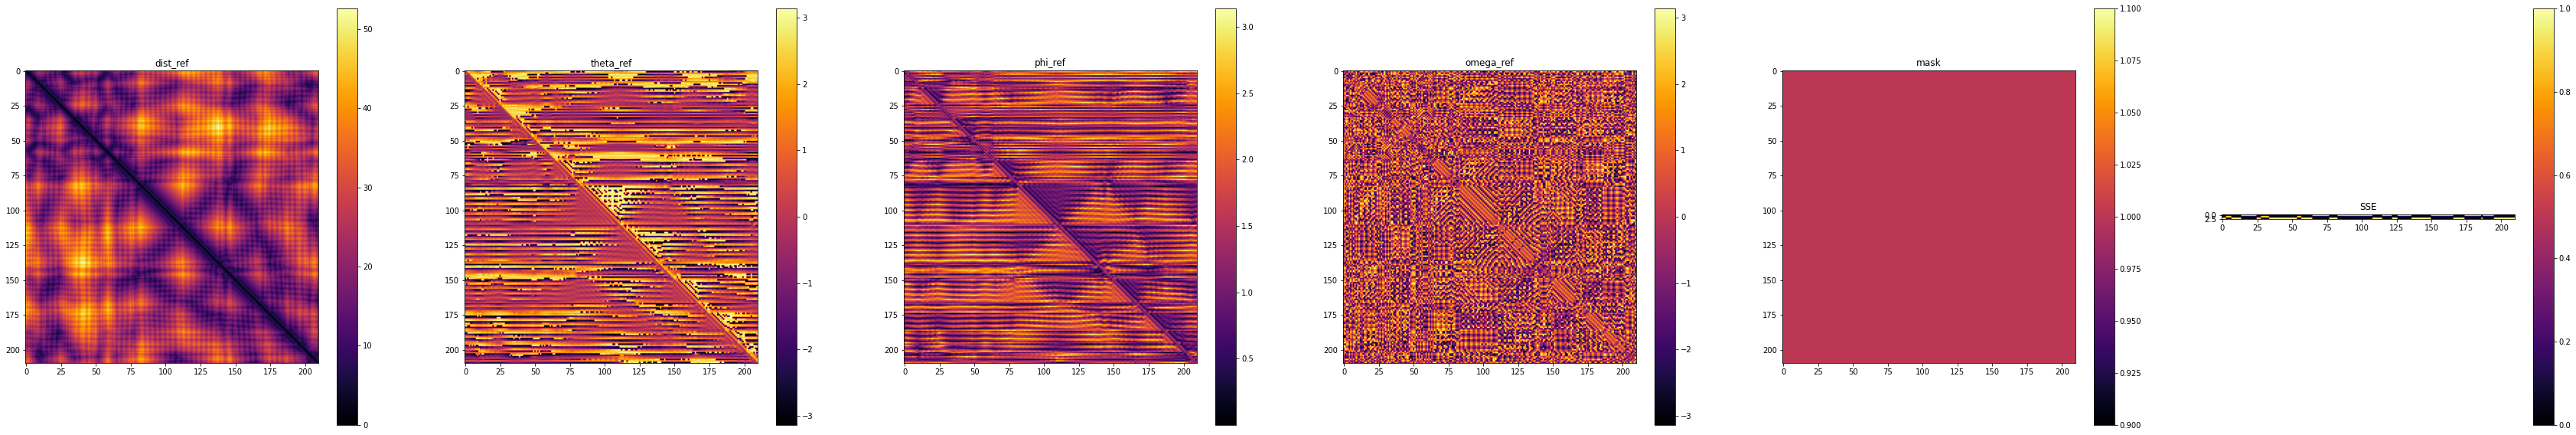

In [22]:
import h5py
file_list = glob.glob("/home/shared/pdb/*.pdb")
file_list.sort()
print(len(file_list))

# file_list= file_list[6637:]

save_path = "/ssd/Protein_extracted_data"#/home/jupyter-jathurshan/Protein_extracted_data"
if not os.path.exists(save_path):
        os.mkdir(save_path)
count = 0
print("=",end = '')
c = -1
for pdb_file in file_list:
    c+=1
    
    # print(pdb_file)
    # if pdb_file in exception:
    #     continue
    try: 
        # Get SSE
        sse,_ = onehot_encode(pdb_file)
    except:
        continue
        
    X = prep_input(pdb_file)
    
    dist_ref = X['dist_ref']
    seq = X['seq'][0]
    theta_ref = X['Angles_ref']['theta_ref']
    phi_ref = X['Angles_ref']['phi_ref']
    omega_ref = X['Angles_ref']['omega_ref']
    mask = X["mask"]
    
    # print(mask.shape)
    if mask.sum()!= (mask.shape[0]*mask.shape[1]):
        continue
    
    
    if c==0:
        print(dist_ref.shape,theta_ref.shape,phi_ref.shape,omega_ref.shape,mask.shape,sse.shape,np.array([seq]))
        plot_sub_plots(1,6,[dist_ref,theta_ref,phi_ref,omega_ref,mask,sse],
                       ['dist_ref','theta_ref','phi_ref','omega_ref','mask','SSE'],cmap = 'inferno')
        c+=1
    
    
    file_name = pdb_file.split('/')[-1].split('.')[0]
    # print(f'{save_path}/{file_name}.h5')
    # break
    with h5py.File(f'{save_path}/{file_name}.h5', "w") as hf:
        hf.create_dataset('dist_ref', data=dist_ref)
        hf.create_dataset('theta_ref', data=theta_ref)
        hf.create_dataset('phi_ref', data=phi_ref)
        hf.create_dataset('omega_ref', data=omega_ref)
        hf.create_dataset('mask', data=mask)
        hf.create_dataset('sse', data=sse)
        hf.create_dataset('seq', data=seq)
        # hf.create_dataset('Pad', data=4-sample.shape[-1]%4)
    hf.close()
    # print(sample.detach().cpu().squeeze().numpy().shape,mask.detach().cpu().squeeze().numpy().shape)#,pad.shape)
    # break
    if (count+1)%1000 == 0:
        print("=",end = '')
    count+=1
# sample_list = np.array(sample_list)
# mask_list = np.array(mask_list)
# pad_list = np.array(pad_list)


In [24]:
#15051
print(c)
file_list = glob.glob(f"{save_path}/*.h5")
file_list.sort()
print(len(file_list))

15051
9058


In [17]:
file_list = glob.glob("/ssd/*")
file_list.sort()
print(len(file_list))

0
